Universidad Técnica Federico Santa Maria.                                                                    

Departamento Ingeniería Mecánica


Profesor: Christopher Cooper

Nombre: Javier Gómez Gajardo



IPM-407 - Modelación computacional con algoritmos Rapidos

# Métodos basados en transformadas de Fourier

Sea la siguiente ecuación de Poisson

$$\frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2}=\frac{1}{\pi^2}\left[ 30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4\pi^2\left(\frac{x}{\pi}-1\right)\sin(2y)\right]\quad (1)$$ 


en el cuadrado $0\leq x\leq \pi$ y $0\leq y \leq \pi$ con condiciones de contorno $\phi(0,y) = \phi(\pi,y)=\phi(x,0) =\phi(x,\pi)=0$. 

El objetivo de este proyecto es resolver esta ecuación de Poisson con dichas condiciones usando:

1. Método espectral
2. Diferencias finitas aceleradas con FFT en 2D
3. Diferencias finitas aceleradas con FFT en 1D

Para hacer la comparación se utilizaran mallas de $N=16,$ $32,$ $64,$ $128$ nodos para la dirección $x$ e $y$

Ademas se sabe que la solución analitica para esta ecuación es:

$$\phi(x,y)=15\left(\left(\frac{x}{\pi}  \right)^2-\frac{x}{\pi}\right)\left(\left(\frac{y}{\pi}  \right)^2-\frac{y}{\pi}\right)-\sin(2y)\frac{\sinh(2\pi(\frac{x}{\pi}-1))}{\sinh(2\pi)}+\left(\frac{x}{\pi}-1 \right)\sin(2y) \quad (2)$$


# Preambulo

En un primer momento se importan las librerias que seran necesarias para los calculos a realizar.


In [1]:
#se importan las librerias necesarias
import numpy
import math
from numpy import pi, sin, cos, exp, real, imag, sinh, empty, zeros
from time import time

from numpy.fft import rfft,irfft

from matplotlib import pyplot, cm
from matplotlib import rcParams
from numba import jit
from scipy import sparse
from scipy.sparse.linalg import spsolve
%matplotlib inline

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 8

A continuación se definen los parametros espaciales y la cantidad de mallas a utilizar.
Anteriormente se menciono que las mallas tienen $N = 16, 32, 64, 128$ nodos por dirección con lo cual da un total de cuatro mallas probar. Independiente de esto se utilizara una mayor cantidad de mallas para observar mejor el comportamiento del error o de la complejidad.   

In [2]:
N_in=16
Num_mallas = 8
N = empty(Num_mallas, dtype=int)

for i in range(len(N)):
    N[i]=N_in*2**i
    #N[i]=((N_in)*2**i)+1

L = pi

error_inf = empty([4,len(N)], dtype=float)
error_eu = empty([4,len(N)], dtype=float)
tiempo = empty([4,len(N)],dtype=float)

print N

[  16   32   64  128  256  512 1024 2048]


Se llamara $f$ la función que se observa en el miembro derecgo de la ecuación de poisson, es decir_

$$f(x,y)=\frac{1}{\pi^2}\left[ 30\left(\left(\frac{x}{\pi}\right)^2-\frac{x}{\pi}\right)+30\left(\left(\frac{y}{\pi}\right)^2-\frac{y}{\pi}\right)-4\pi^2\left(\frac{x}{\pi}-1\right)\sin(2y)\right]\quad (3)$$

A continuación se estableceran las rutinas que permita calcular cada uno de los valores de $f$ dentro de la malla y el valor teorico de la función $\phi$

In [3]:
# @jit
def function_f(h,N):
    f = empty([N,N], dtype=float)
    for j in range(N):
        for i in range(N):
            f[j,i] = (1/pi**2)*(30.*(((i*h/pi)**2)
                      -i*h/pi)+30.*(((j*h/pi)**2)
                      -j*h/pi)-4.*(pi**2)*((i*h/pi)
                                    -1)*sin(2*j*h))
                        
    return f


def phi_teorico(h,N):
    phi = empty([N,N], dtype=float)
    for j in range(N):
        for i in range(N):
            phi[j,i] = (15.*(((i*h/pi)**2)
                        -(i*h/pi))*(((j*h/pi)**2)
                        -(j*h/pi))-sin(2.*j*h)*
                        (sinh(2.*pi*((i*h/pi)
                        -1))/sinh(2.*pi))
                        + ((i*h/pi)-1)*sin(2.*j*h))
           
    return phi


# Con la siguiente función se pretende ordenar 
#vectores en forma de matriz para asi poder determinar maximos
# en caso de ser necesario.
@jit
def matrix_to_vector(matrix,N):
    NN = (N-2)*(N-2)
    vector = numpy.empty([NN])
    j = 1
    k = 1
    for i in range(NN):
        vector[i] = matrix[j,k]
        k = k+1
        if k == (N):
            j = j+1
            k = 1       
    return vector

# Recive un vector y devuelve la norma infinita 
#y la norma eclideana del vector.
def norma(vector,H):
    norm = numpy.zeros(2)
    norm[0] = max(abs(vector))
    norm[1] = H*(sum(vector**2)**(0.5))
    return norm

## Transformada discreta del Seno

EL de la transformada del seno (inver y directa) que esta definida en el libro $Fundamentals$ $of$ $Engineering$ $Numerical$ $Analysis$ de Parviz Moin esta dada por:

$$f_j=\sum_{k=0}^N F_k sin(kx_j) \quad j=0,1,2,...,N\quad (4)$$
$$F_k = \frac{2}{N} \sum_{j=0}^N f_j sin(kx_j) \quad k=0,1,2,...,N\quad (5)$$

para unidimensional, y para bidimensional:

$$f_{ji}=\sum_{k=0}^N\sum_{l=0}^N F_{kl} sin(kx_j)sin(ly_i) \quad j,i=0,1,2,...,N\quad (6)$$
$$F_{kl} = \frac{4}{N^2} \sum_{j=0}^N\sum_{i=0}^N f_{ji} sin(kx_j)sin(ly_i) \quad k,l=0,1,2,...,N\quad (7)$$

Usando la implementación de http://www-personal.umich.edu/~mejn/computational-physics/dcst.py, la transformada de Fourier discreta para la función seno es: 


In [4]:
######################################################################
# 1D DST Type-I

def dst(y):
    N = len(y)
    y2 = empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -imag(rfft(y2))[:N]
    a[0] = 0.0

    return a


######################################################################
# 1D inverse DST Type-I

def idst(a):
    N = len(a)
    c = empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0

    return y


######################################################################
# 2D DST

def dst2(y):
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dst(y[i,:])
    for j in range(N):
        b[:,j] = dst(a[:,j])

    return b


######################################################################
# 2D inverse DST

def idst2(b):
    M = b.shape[0]
    N = b.shape[1]
    a = empty([M,N],float)
    y = empty([M,N],float)

    for i in range(M):
        a[i,:] = idst(b[i,:])
    for j in range(N):
        y[:,j] = idst(a[:,j])

    return y

## Solvers

Estos se desarrollan a partir de reemplazar las transformadas de $f$ y de $\phi$ de la ecuación (1) y (2) con las definiciones entregadas en (4), (5), (6) y (7) como se muestra a continuación:

### Método Espectral

Primero se plantea la derivada espectral pa la función $\phi$ y luego se reemplaza:

$$\frac{\partial^2 \phi}{\partial x^2} = \sum_{k=0}^N\sum_{l=0}^N \Phi_{kl} (-k^2)\sin(kx_i)\sin(ly_j) \quad y \quad \frac{\partial^2 \phi}{\partial y^2} = \sum_{k=0}^N\sum_{l=0}^N \Phi_{kl} (-l^2)\sin(kx_i)\sin(ly_j)$$

reemplazando en (1),

$$\Rightarrow \sum_{k=0}^N\sum_{l=0}^N (-k^2-l^2)\Phi_{kl}\sin(kx_i)\sin(ly_j) = \sum_{k=0}^N\sum_{l=0}^N F_{kl}\sin(kx_i)\sin(ly_j)$$

Con lo que se obtiene:

$$ \Phi_{kl}=\frac{-F_{kl}}{k^2+l^2}\quad (8)$$

### Método de Diferencias finitas en 2D:

Para este caso se debe planteal la la ecuación (1) segun su discretización por diferencias finitas con un esquema centrado de segundo orden de la forma:

$$\frac{-\phi_{i-1j}-\phi_{ij-1}+4\phi_{ij}-\phi_{i+1j}-\phi_{ij+1}}{h^2}=-f_{ij} \quad (*)$$

Posteriormente se plantean los terminos de $\phi$ que requiere la ecuación (*). Notar que en este caso, para poder separar el temino $-1$ o $+1$ de los contadores $i$ y $j$ se requiere aplicar una identidad trigonometrica. Lo planteado anteriormete quede de la forma:

$$\phi_{i-1j} = \sum_{k=0}^N\sum_{k=0}^N\Phi_{kl}(\sin(kx_i)\cos(kh)-\cos(kx_i)\sin(kh))\sin(ly_j)$$
$$\phi_{i+1j} = \sum_{k=0}^N\sum_{k=0}^N\Phi_{kl}(\sin(kx_i)\cos(kh)+\cos(kx_i)\sin(kh))\sin(ly_j)$$
$$\phi_{ij-1} = \sum_{k=0}^N\sum_{k=0}^N\Phi_{kl}\sin(kx_i)(\sin(ly_j)\cos(lh)-\cos(ly_j)\sin(lh)$$
$$\phi_{ij+1} = \sum_{k=0}^N\sum_{k=0}^N\Phi_{kl}\sin(kx_i)(\sin(ly_j)\cos(lh)+\cos(ly_j)\sin(lh)$$

Una vez planteadas estas transformadas, estas se reemplazan en la ecuación (*), lo que queda de la forma:

$$\sum_{k=0}^N\sum_{l=0}^N\Phi_{kl}(-2\cos(kh)+4-2\cos(lh))\sin(kx_i)\sin(ly_j)=-h^2\sum_{k=0}^N \sum_{l=0}^N F_{kl}\sin(kx_i)\sin(ly_j)$$

de lo que finalmente se obtiene:

$$ \Phi_{kl}=\frac{h^2\cdot F_{kl}}{2(cos(kh)+cos(lh))-4}\quad (9)$$

### Método de Diferencias finitas en 1D:

Para este metodo es necesario volver a plantear (1) como se ve en (*), pero las transformadas del seno solo se plantearan en una dimension como se muestra a continuación:

$$\phi_{i-1j}=\sum_{k=0}^N\Phi_{kj}(\sin(kx_i)\cos(kh)-\cos(kx_i)\sin(kh))$$
$$\phi_{i+1j}=\sum_{k=0}^N\Phi_{kj}(\sin(kx_i)\cos(kh)+\cos(kx_i)\sin(kh))$$
$$\phi_{ij-1}=\sum_{k=0}^N\Phi_{kj-1}\sin(kx_i)$$
$$\phi_{ij+1}=\sum_{k=0}^N\Phi_{kj+1}\sin(kx_i)$$

que al reemplazar en (*) queda de la forma:

$$\sum_{k=0}^N-\Phi_{kj}(2\cos(kh)+4)-(\Phi_{kj-1}+\Phi_{kj+1})=-h^2\sum_{k=0}^N F_{kj}$$

de lo que finalmente se obtiene:

$$-\Phi_{kj-1}+(4+2cos(kh))\Phi_{kj}-\Phi_{kj+1}=-h^2F_{kj}\quad (10)$$

Notar que la ecuación (10) representa un sistema tridiagonal.

#### Nota: $\Delta x= \Delta y = h = \frac{\pi}{N}$

Los solvers que se muestran a continuación hacen uso de estas expresiones con la finalidad de calcular numericamente el campo $\phi$. Los pasos que sigen son:

1) Calcular $f$ haciendo uso de la ecuación (3), para ello se ocupa una función predefinida en la seccoón Preambulo llamada $function\_f$

2) Calcular $F$ con la transformada del seno para $f$. Se usa la función $dst2$ para el metodo espectral y el 2D y la función $dst$ para el metodo en 1D.

3) Con las expresiones definidas en (8), (9) y (10), segun corresponda al metodo utilizado, se calcula la función $\Phi$. Notar que para el método en 1D se debe resolver un sistema tridiagonal por lo cual se crean dos solvers, uno que realiza el calculo a partir de matrices y otro que se aprovecha de que la matriz sea tridiagonal.

4) Volver a la variable $phi$ a partir de la transformada inversa del seno para $\Phi$ usando las funciones $idst2$ e $idst$ segun corresponda.

In [5]:
#@jit
def solve_espectral(h,N):
    f = function_f(h,N)
    ff = dst2(f)
    pphi = empty([N,N], dtype = float)
    for l in range(N):
        for k in range(N):
            if (k + l) == 0:
                pphi[l,k] = 0.
            else:
                pphi[l,k] = -ff[l,k]/((l**2)+(k**2))
    phi = idst2(pphi)
        
    return phi

#@jit
def solve_DF_2D(h,N):
    f = function_f(h,N)
    ff = dst2(f)
    pphi = zeros([N,N])
    for l in range(1,N-1):
        for k in range(1,N-1):
            pphi[l,k] = ff[l,k]*(h**2)/(2*(cos(k*h)
                                    +cos(l*h))-4)
    phi = idst2(pphi)
    
    return phi

#@jit
def solve_DF_1D(h,N):
    f = function_f(h,N)
    ff = zeros((N, N))
    for j in range(N):
        ff[:, j] = dst(f[:, j])
    pphi = numpy.zeros((N, N))
    for k in range(N):
        A = zeros((N, N))
        for i in range(N):
            for j in range(N):
                if abs(i - j) == 1:
                    A[i, j] = -1
                if i == j:
                    A[i, j] = 4. - 2.*cos(k*h)
        A_sparse = sparse.csr_matrix(A)
        b = zeros(N)
        for j in range(N):
            b[j] = -h**2 * ff[k, j]
        pphi[k, :N] = spsolve(A_sparse,b)
    phi = zeros((N, N))
    for j in range(N):
        phi[:, j] = idst(pphi[:, j])  
        
    return phi 

#Este codigo realiza la misma tarea que el anterior para 
#1D salvo que la forma de calcular los sistemas
#tridiagonales se aprovecha el algoritmo de Thomas
def solve_DF_1D_thomas(h,N):
    f = function_f(h,N)
    ff = zeros((N, N))
    for j in range(N):
        ff[:, j] = dst(f[:, j])
    pphi = numpy.zeros((N, N))
    c = empty([N-1], dtype=float)
    c[:] = -1.
    for k in range(N):
        a = empty(N, dtype=float)
        a[:] = 4. - 2.*cos(k*h)
        b = zeros(N)
        for j in range(N):
            b[j] = -h**2 * ff[k, j]
        pphi[k, :] = thomassolve(c, a, c, b)
    phi = zeros((N, N))
    for j in range(N):
        phi[:, j] = idst(pphi[:, j])
        
    return phi 

Para el caso 1D, se puede aprovechar un caso particular de la eliminacion Gaussiana para resolver sistemas tridiagonales que es el algoritmo de Thomas definido a continuación.

In [6]:
# Algoritmo de thomas

def thomassolve(a,b,c,d):
    '''
    b: diagonal principal
    a y c: diagonales secundarias
    d: vector del sistema Ax = d
    x: solcion del sistema
    '''
    
    n = len(b)
    
    cth = numpy.empty([n-1], dtype=float)
    dth = numpy.empty([n], dtype=float)
    xth = numpy.empty([n], dtype=float)
    
    cth[0] = c[0]/b[0]
    dth[0] = d[0]/b[0]
    
    for i in range(1,n-1):
        cth[i] = c[i]/(b[i]-cth[i-1]*a[i-1])
    for i in range(1,n):
        dth[i] = (d[i]-dth[i-1]*a[i-1])/(b[i]-cth[i-1]*a[i-1])
    
    xth[n-1] = dth[n-1]
    
    for i in range(n-2,-1,-1):
        xth[i] = dth[i]-cth[i]*xth[i+1]
    
    return xth

# Implementación

Se realizan los calculos para obtener $\phi$ de forma numerica usando los solvers $solve_espectral$, $solve_DF_2D$ y $solve_DF_1D$. Se le pide al codigo que muestre por pantalla el reporte del error obtenido segun norma infinita y euclideana, el tiempo que demoraron estos solvers en hacer los calculos y cuanta memoria ocuparon por malla.

In [7]:
t1total = time()
memory = empty([4,len(N)])

for i in range(len(N)):
    h = L/(N[i]-1)
    X = numpy.linspace(0.0,L, N[i]) 
    Y = numpy.linspace(0.0,L, N[i]) 
    phi_teo_aux = phi_teorico(h,N[i])

    t1 = time()
    phi_espectral_aux = solve_espectral(h,N[i])
    t2 = time()
    tiempo[0,i] = t2-t1
    error_espectral_M = phi_teo_aux-phi_espectral_aux
    error_espectral_V = matrix_to_vector(error_espectral_M,N[i])
    error_espectral = norma(error_espectral_V,h)
    error_inf[0,i] = error_espectral[0]
    error_eu[0,i] = error_espectral[1]
    memory[0,i] =  (12*4+4*4*N[i]+4*4*N[i]**2)/(10**3)
    
    t1 = time()
    phi_DF_2D_aux = solve_DF_2D(h,N[i])
    t2 = time()
    tiempo[1,i] = t2-t1
    error_DF_2D_M = phi_teo_aux-phi_DF_2D_aux
    error_DF_2D_V = matrix_to_vector(error_DF_2D_M,N[i])
    error_DF_2D = norma(error_DF_2D_V,h)
    error_inf[1,i] = error_DF_2D[0]
    error_eu[1,i] = error_DF_2D[1]
    memory[1,i] =  (12*4+4*4*N[i]+4*4*N[i]**2)/(10**3)
    
    t1 = time()
    phi_DF_1D_aux = solve_DF_1D(h,N[i])
    t2 = time()
    tiempo[2,i] = t2-t1
    error_DF_1D_M = phi_teo_aux-phi_DF_1D_aux
    error_DF_1D_V = matrix_to_vector(error_DF_1D_M,N[i])
    error_DF_1D = norma(error_DF_1D_V,h)
    error_inf[2,i] = error_DF_1D[0]
    error_eu[2,i] = error_DF_1D[1]
    memory[2,i] = (13*4+7*4*N[i]+2*4*(N[i]-1)+6*4*N[i]**2)/(10**3)

    
    print 'Metodos:    Espectral        | DF 2D             | DF 1D'
    print 'cantidad de nodos:', N[i],'x',N[i]
    print 'error inf: ',error_inf[0,i],'| ',error_inf[1,i],'| ',error_inf[2,i]
    print 'error eu:  ',error_eu[0,i],' | ',error_eu[1,i],' | ',error_eu[2,i]
    print 'tiempo [s]:    ',tiempo[0,i],'   | ',tiempo[1,i],'   | ',tiempo[2,i]
    print 'memoria [kb]:   ',memory[0,i],'   | ',memory[1,i],'   | ',memory[2,i]
    print
    
    
t2total = time()
    
print 'Fin, el tiempo total fue de ', t2total-t1total,'[s]'


Metodos:    Espectral        | DF 2D             | DF 1D
cantidad de nodos: 16 x 16
error inf:  0.223745611926 |  0.225606613031 |  0.362772584994
error eu:   0.225336053337  |  0.229612891057  |  0.454444426312
tiempo [s]:     0.00360512733459    |  0.00282001495361    |  0.00945901870728
memoria [kb]:    4.0    |  4.0    |  6.0

Metodos:    Espectral        | DF 2D             | DF 1D
cantidad de nodos: 32 x 32
error inf:  0.137162885071 |  0.138121186243 |  0.215350793588
error eu:   0.139064592753  |  0.140410869643  |  0.254580852963
tiempo [s]:     0.00638198852539    |  0.0090000629425    |  0.0235369205475
memoria [kb]:    16.0    |  16.0    |  25.0

Metodos:    Espectral        | DF 2D             | DF 1D
cantidad de nodos: 64 x 64
error inf:  0.0868336712018 |  0.0870217916489 |  0.117741493807
error eu:   0.0786376894853  |  0.0789921730973  |  0.134520202876
tiempo [s]:     0.0203971862793    |  0.0305268764496    |  0.08185505867
memoria [kb]:    66.0    |  66.0    |  100.

## Modificación 1D DF

Aqui se modifica el metodo de diferencias finitas en 1D para incluir el algoritmo de tomas en la resolución de los sistemas tridiagonales usando $solve_DF_1D_thomas$.

In [8]:
t1total = time()

for i in range(len(N)):
    h = L/(N[i]-1)
    X = numpy.linspace(0.0,L, N[i]) 
    Y = numpy.linspace(0.0,L, N[i]) 
    phi_teo_aux = phi_teorico(h,N[i])
    
    t1 = time()
    phi_DF_1Dt_aux = solve_DF_1D_thomas(h,N[i])
    t2 = time()
    tiempo[3,i] = t2-t1
    error_DF_1Dt_M = phi_teo_aux-phi_DF_1Dt_aux
    error_DF_1Dt_V = matrix_to_vector(error_DF_1Dt_M,N[i])
    error_DF_1Dt = norma(error_DF_1Dt_V,h)
    error_inf[3,i] = error_DF_1Dt[0]
    error_eu[3,i] = error_DF_1Dt[1]
    memory[3,i] = (14*4+7*4*N[i]+3*4*(N[i]-1)+5*4*N[i]**2)/(10**3 )
    
    print 'Metodos: DF 1D thomas'
    print 'cantidad de nodos:', N[i],'x',N[i]
    print 'error inf: ',error_inf[3,i]
    print 'error eu:  ',error_eu[3,i]
    print 'tiempo [s]:    ',tiempo[3,i]
    print 'memoria [kb]:  ',memory[3,i]
    print

    
t2total = time()
    
print 'Fin, el tiempo total fue de ', t2total-t1total,'[s]'


Metodos: DF 1D thomas
cantidad de nodos: 16 x 16
error inf:  0.362772584994
error eu:   0.454444426312
tiempo [s]:     0.00284099578857
memoria [kb]:   5.0

Metodos: DF 1D thomas
cantidad de nodos: 32 x 32
error inf:  0.215350793588
error eu:   0.254580852963
tiempo [s]:     0.00762891769409
memoria [kb]:   21.0

Metodos: DF 1D thomas
cantidad de nodos: 64 x 64
error inf:  0.117741493807
error eu:   0.134520202876
tiempo [s]:     0.0243468284607
memoria [kb]:   84.0

Metodos: DF 1D thomas
cantidad de nodos: 128 x 128
error inf:  0.0614912137294
error eu:   0.069104460518
tiempo [s]:     0.105109930038
memoria [kb]:   332.0

Metodos: DF 1D thomas
cantidad de nodos: 256 x 256
error inf:  0.0314121128541
error eu:   0.0350179055199
tiempo [s]:     0.394464969635
memoria [kb]:   1321.0

Metodos: DF 1D thomas
cantidad de nodos: 512 x 512
error inf:  0.0158740233962
error eu:   0.0176259979795
tiempo [s]:     1.38204789162
memoria [kb]:   5263.0

Metodos: DF 1D thomas
cantidad de nodos: 1024

# Resultados para $\phi$

Forma gráfica de los resultados para la función $\phi$ (teorico, numerico)

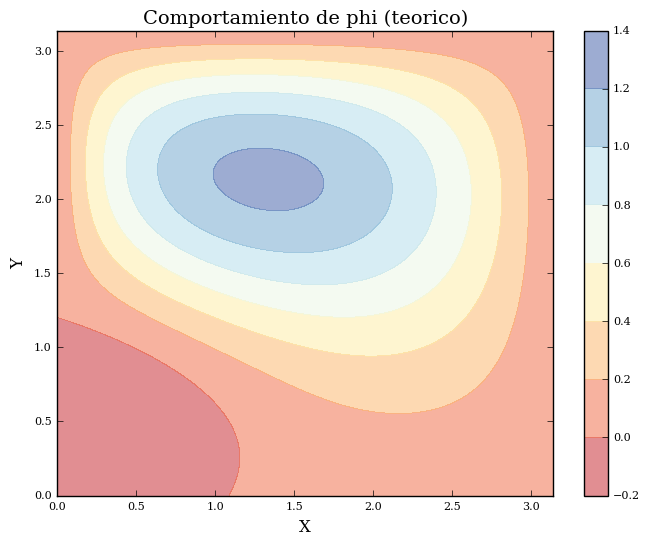

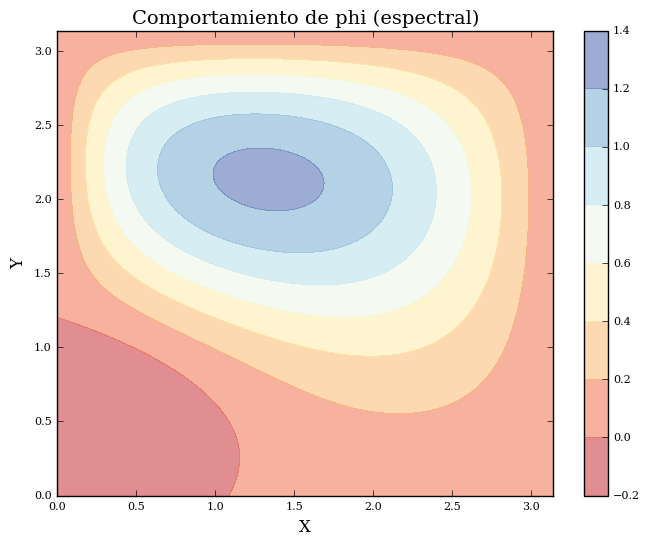

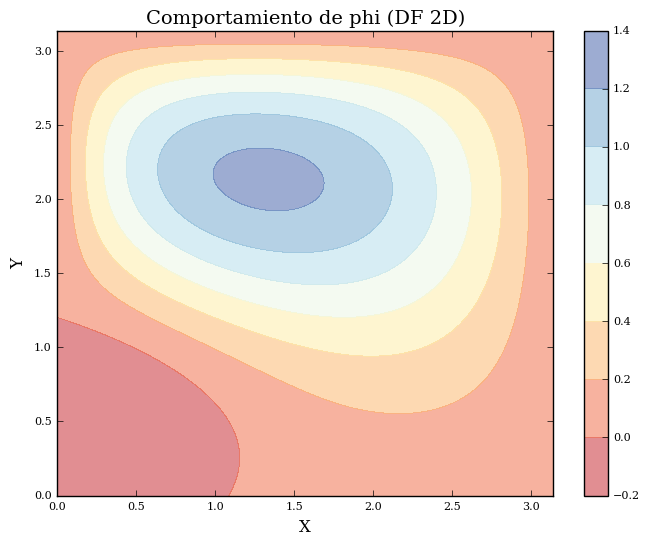

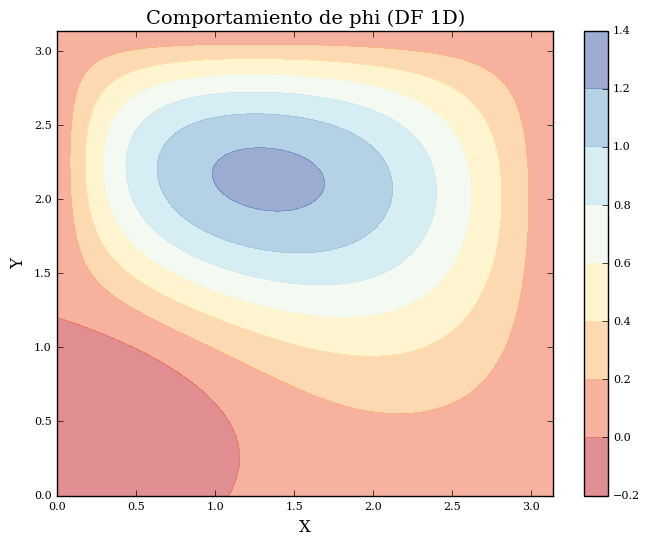

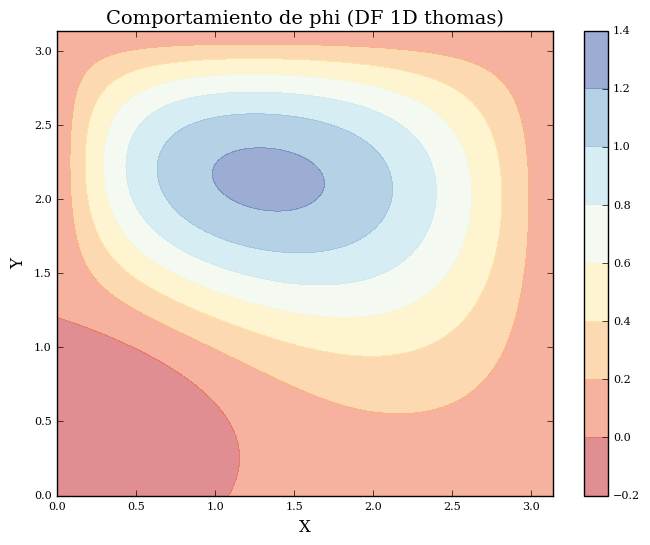

In [9]:
N_finito = N[len(N)-1]


fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_teo_aux, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (teorico)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_espectral_aux, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (espectral)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_DF_2D_aux, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (DF 2D)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_DF_1D_aux, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (DF 1D)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

fig = pyplot.figure(figsize=(8,6), dpi=50)
pyplot.contourf(X, Y, phi_DF_1Dt_aux, alpha=0.5,facecolor = 'w', cmap=cm.RdYlBu)
pyplot.colorbar()
pyplot.title('Comportamiento de phi (DF 1D thomas)', fontsize = 14)
pyplot.xlabel('X', fontsize = 12)
pyplot.ylabel('Y', fontsize = 12)

## Convergencia del error

[  16   32   64  128  256  512 1024 2048]


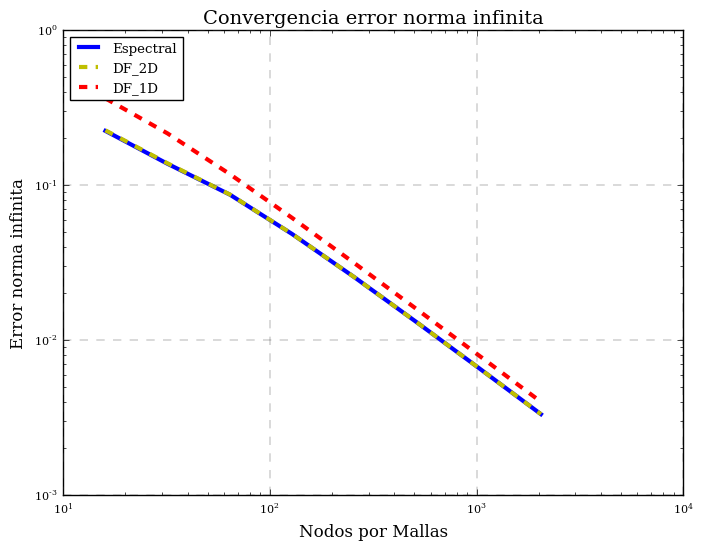

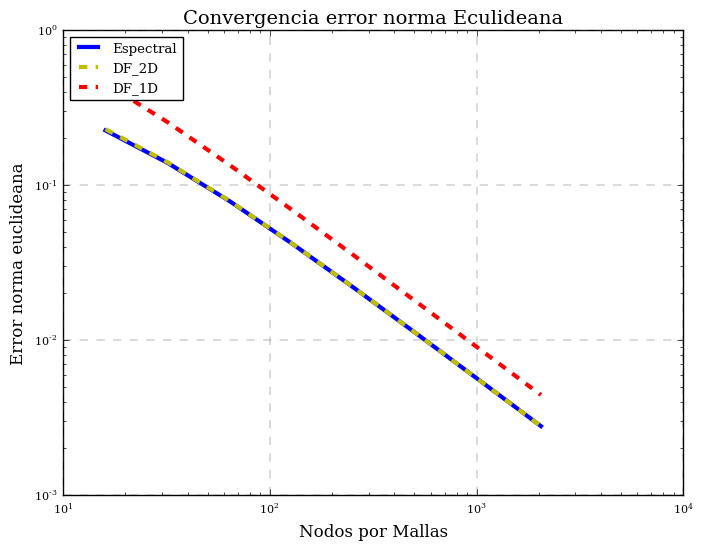

In [10]:
print N    
    
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsEespectral = pyplot.plot(N, error_inf[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsEDF2D = pyplot.plot(N, error_inf[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsEDF1D = pyplot.plot(N, error_inf[2,:], 'r--', linewidth = 3, label = 'DF_1D')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Convergencia error norma infinita", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("Error norma infinita", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsEespectral = pyplot.plot(N, error_eu[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsEDF2D = pyplot.plot(N, error_eu[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsEDF1D = pyplot.plot(N, error_eu[2,:], 'r--', linewidth = 3, label = 'DF_1D')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Convergencia error norma Eculideana", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("Error norma euclideana", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

[  16   32   64  128  256  512 1024 2048]


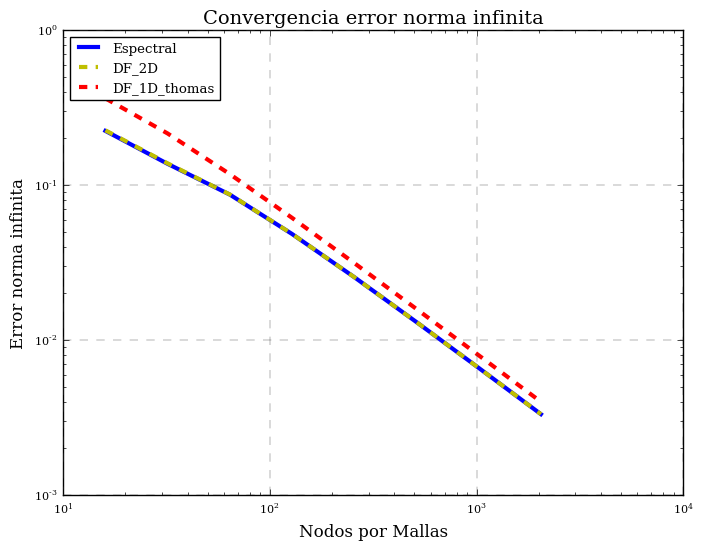

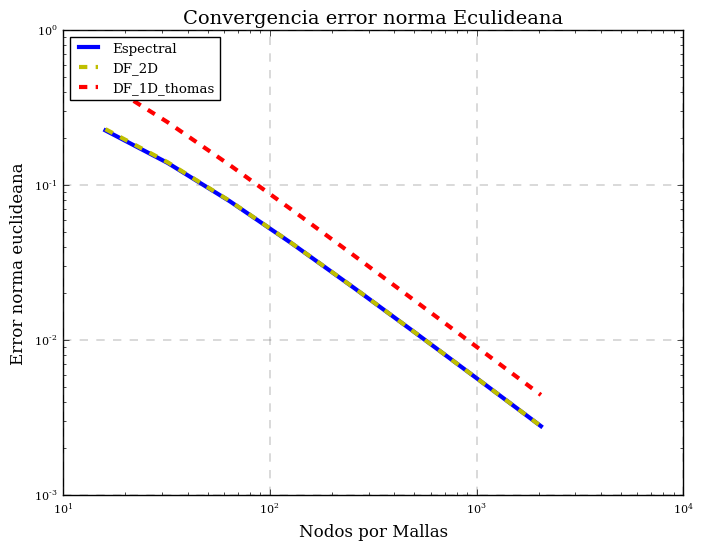

In [11]:
print N    
    
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsEespectral = pyplot.plot(N, error_inf[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsEDF2D = pyplot.plot(N, error_inf[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsEDF1Dt = pyplot.plot(N, error_inf[3,:], 'r--', linewidth = 3, label = 'DF_1D_thomas')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Convergencia error norma infinita", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("Error norma infinita", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsEespectral = pyplot.plot(N, error_eu[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsEDF2D = pyplot.plot(N, error_eu[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsEDF1D = pyplot.plot(N, error_eu[3,:], 'r--', linewidth = 3, label = 'DF_1D_thomas')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Convergencia error norma Eculideana", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("Error norma euclideana", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

## Complejidad algoritmica

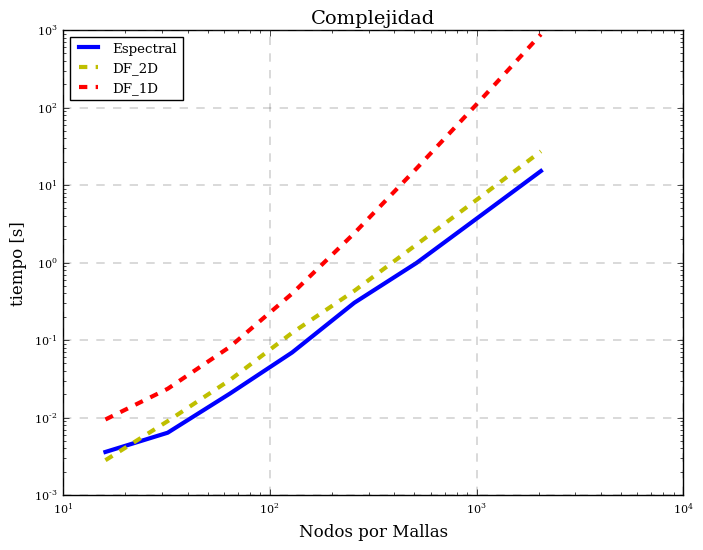

In [12]:
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvstEespectral = pyplot.plot(N, tiempo[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvstEDF2D = pyplot.plot(N, tiempo[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvstEDF1D = pyplot.plot(N, tiempo[2,:], 'r--', linewidth = 3, label = 'DF_1D')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Complejidad", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("tiempo [s]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()



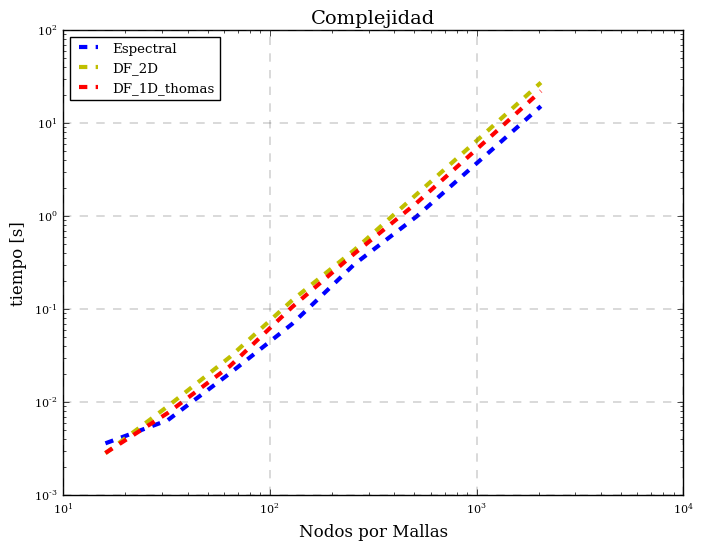

In [13]:
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvstEespectral = pyplot.plot(N, tiempo[0,:], 'b--',linewidth = 3, label = 'Espectral')
NvstEDF2D = pyplot.plot(N, tiempo[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvstEDF1Dt = pyplot.plot(N, tiempo[3,:], 'r--', linewidth = 3, label = 'DF_1D_thomas')

pyplot.legend(loc = 2)
pyplot.xscale("log")
pyplot.yscale("log")
pyplot.title("Complejidad", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("tiempo [s]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

## Uso de memoria

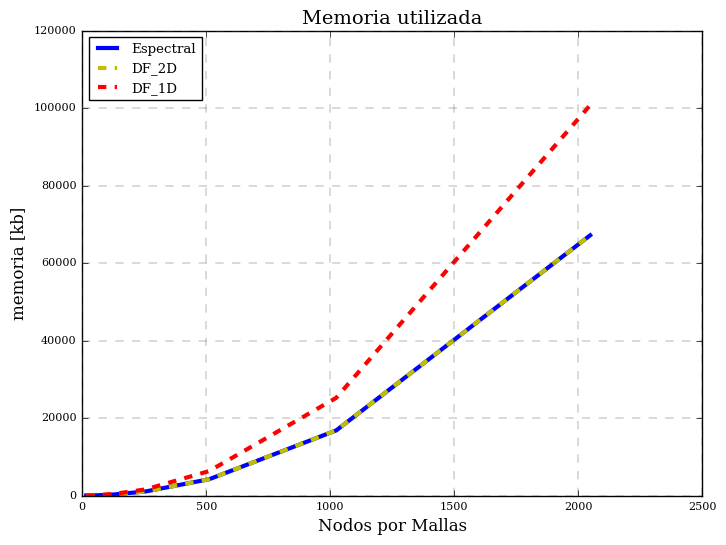

In [14]:
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsmEespectral = pyplot.plot(N, memory[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsmEDF2D = pyplot.plot(N, memory[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsmEDF1D = pyplot.plot(N, memory[2,:], 'r--', linewidth = 3, label = 'DF_1D')

pyplot.legend(loc = 2)
#pyplot.xscale("log")
#pyplot.yscale("log")
pyplot.title("Memoria utilizada", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("memoria [kb]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

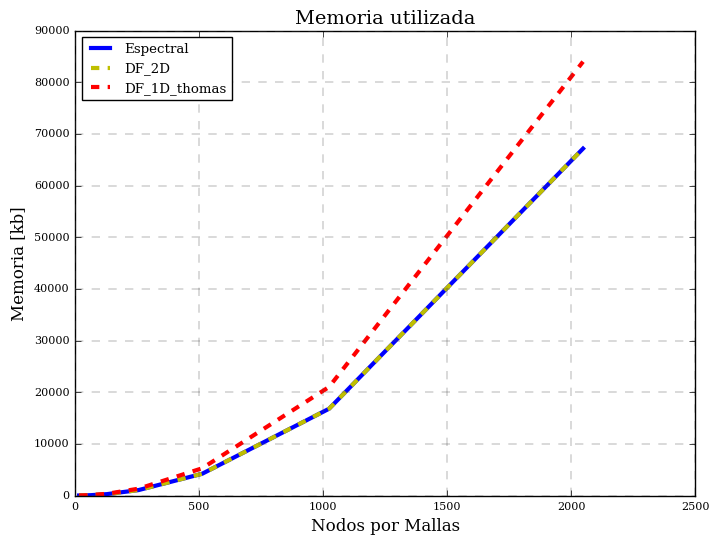

In [15]:
fig = pyplot.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
NvsmEespectral = pyplot.plot(N, memory[0,:], 'b-',linewidth = 3, label = 'Espectral')
NvsmEDF2D = pyplot.plot(N, memory[1,:], 'y--', linewidth = 3,label = 'DF_2D')
NvsmEDF1D = pyplot.plot(N, memory[3,:], 'r--', linewidth = 3, label = 'DF_1D_thomas')

pyplot.legend(loc = 2)
#pyplot.xscale("log")
#pyplot.yscale("log")
pyplot.title("Memoria utilizada", fontsize = 14)
pyplot.xlabel("Nodos por Mallas", fontsize = 12)
pyplot.ylabel("Memoria [kb]", fontsize = 12)
#pyplot.axis([10**(1.5),10**5,10**(-2),10**3.8])
pyplot.grid(True)
pyplot.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
pyplot.show()

# Analisis y Conclusiones 

De forma cualitativa, se observa que el la transformada de Fourier del seno si es capaz de representar cualitativamente la función $\phi$, segun lo que se aprecia en los gráficos de la seccion "Resultados para $\phi$". En contraste con eso, si bien los gráficos de convergencia del error si muestran que este se reduce, y para los tres métodos las curvas de convergencia, al menos la de la norma infinita, se acercan a un punto en comun, la convergencia es de orden lineal, lo cual no es el resultado esperado ya que el método espectral deberia arrojar una convergencia espectral y los demas metodos de diferencias finitas deberian arrojar una convergencia concorde al orden de aproximación que estan realizando, que en este caso es de orden cuadratico. Las causas de el posible fallo en la convergencia esperada pueden ser debido a errores en la implementación los cuales no pudieron ser detectados.

En cuanto a la complegidad algoritmica se observa que si bien, el tiempo de calculo no aumenta de forma lineal con respecto al aumento en la cantidad de nodos en la malla, este tampoco aumenta en el orden cuadratico, por lo cual el tipo de convergencia es de $o(N\log(N))$ como se esperaba para los. De aquí se observa que el metodo espectral es el mas rapido para los métodos y sin aplicar modificaciones, el metodo de diferencias finitas en 2D es el que en segundo lugar converge mas rapido. Con respecto a esto, se esperaria que el metodo en 1D convergiera a mayor velocidad que el metodo en 2D, lo cual es posible de lograr, como se observa en el segundo gráfico de complegidad, pero para ello hay que realizar modificaciónes a la forma en la cual se resuelve la matriz tridiagonal del sistema de ecuaciones que se genera a partir de la expresión (10). Realizando la modificación se aprecia como el metodo unidimensional se vuelve mas rapido que el bidimensional lo cual es de esperarce y ademas de eso no se altera la convergencia del error, ya que en ambos casos se resuelve la misma matriz solo que de diferente manera.

En cuanto al uso de memoria, para el método espectral y bidimensional, ambos utilizan la memoria de forma identica ya que sus expresiones y las instrucciones utilizadas en las implementaciones son muy similares, sin embargo el metodo unidimensional ocupa una mayor cantidad de memoria ya que debe generar una matriz para poder resolver el sistema de ecuaciones que produce la expresión (10). Para el caso en que el metodo unidimensional no posee modificaciones la cantidad de memoria es mayor, ya que se esta creando una matriz llena de zeros en algun momento a diferencia de la implementación que ocupa el algoritmo de thomas ya que esta no crea una matriz con tanta informcion si no que ocupa las diagonales donde si hay información util.

Finalmente, se observa que el metodo que presenta un mejor rendimiento, ya sea porque los calculos son mas rapidos o porque parte con un error un poco menor que los demas, es el método espectral. Ademas de eso, la expresión que se obtiene con este metodo es mucho mas manejable que las obtenidas con los otros como se puede ver en las expresiones (8), (9) y (10). Sin embargo, este metodo solo es util cuando la función o el fenomeno así lo permiten, por lo cual es conveniente utilizar las otras alternativas aquí expuestas, por ejemplo, si se necesita que el tiempo de calculos se reduzca y la memoria no es problema es posible utilizar el metodo de diferencias finitas con transformada unidimensional siempre y cuando se busque una forma eficiente de resolver la matriz tridiganal. En caso de que la memoria utilizada si sea un inconveniente es mas sencilla y conveniente la implementacion del método con transformada bidimensional.